<a href="https://colab.research.google.com/github/Mayakshanesht/Semantic-Segmentation/blob/main/apparel_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 36.33 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [4]:
!ls clothing-co-parsing/

annotations  label_list.mat  photos	show_image_anno.m
example.jpg  LICENSE	     README.md	show_pixel_anno.m


In [6]:
images = []
for i in range(1,1001):
     url = './clothing-co-parsing/photos/%04d.jpg'%(i)
     img = cv2.imread(url)
     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
     images.append(tf.convert_to_tensor(img)) 

In [7]:
masks = []
for i in range(1,1001):
     url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
     file = io.loadmat(url)
     mask = tf.convert_to_tensor(file['groundtruth'])
     masks.append(mask) 

AttributeError: ignored

In [8]:
len(images), len(masks)

(1000, 1000)

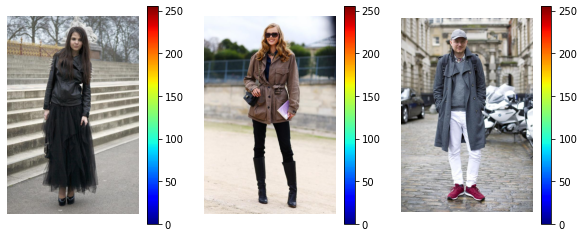

In [9]:
plt.figure(figsize=(10,4))
for i in range(1,4):
     plt.subplot(1,3,i)
     img = images[i]
     plt.imshow(img, cmap='jet')
     plt.colorbar()
     plt.axis('off')
plt.show()

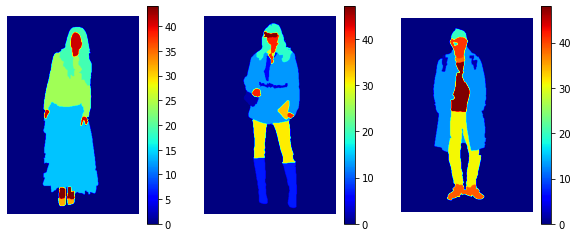

In [10]:
plt.figure(figsize=(10,4))
for i in range(1,4):
     plt.subplot(1,3,i)
     img = masks[i]
     plt.imshow(img, cmap='jet')
     plt.colorbar()
     plt.axis('off')
plt.show() 

In [11]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

In [12]:
base = keras.applications.DenseNet121(input_shape=[128,128,3], 
                                       include_top=False, 
                                       weights='imagenet') 

29097984/29084464 [==============================] - 0s 0us/step


In [13]:
len(base.layers)

427

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.693966 to fit



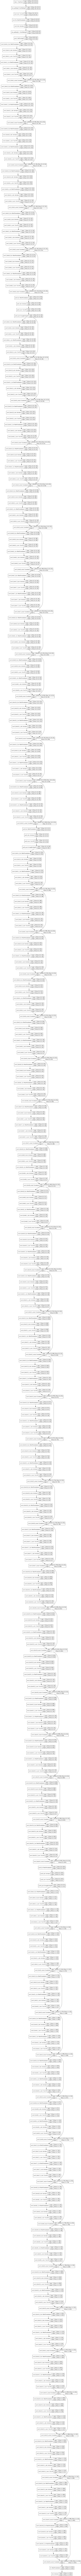

In [14]:
keras.utils.plot_model(base, show_shapes=True)

In [15]:
skip_names = ['conv1/relu', # size 64*64
              'pool2_relu',  # size 32*32
              'pool3_relu',  # size 16*16
              'pool4_relu',  # size 8*8
              'relu'        # size 4*4
              ] 

In [16]:
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
     print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [17]:
downstack = keras.Model(inputs=base.input,
                        outputs=skip_outputs)
downstack.trainable = False 

In [18]:
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
 # Four upstack blocks for upsampling sizes 
 # 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
           pix2pix.upsample(256,3),
           pix2pix.upsample(128,3),
           pix2pix.upsample(64,3)] 

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [19]:
upstack[0].layers

In [20]:
 # define the input layer
 inputs = keras.layers.Input(shape=[128,128,3])
 # downsample 
 down = downstack(inputs)
 out = down[-1]
 # prepare skip-connections
 skips = reversed(down[:-1])
 # choose the last layer at first 4 --> 8
 # upsample with skip-connections
 for up, skip in zip(upstack,skips):
     out = up(out)
     out = keras.layers.Concatenate()([out,skip])
 # define the final transpose conv layer
 # image 128 by 128 with 59 classes
 out = keras.layers.Conv2DTranspose(59, 3,
                                   strides=2,
                                   padding='same',
                                   )(out)
 # complete unet model
 unet = keras.Model(inputs=inputs, outputs=out) 

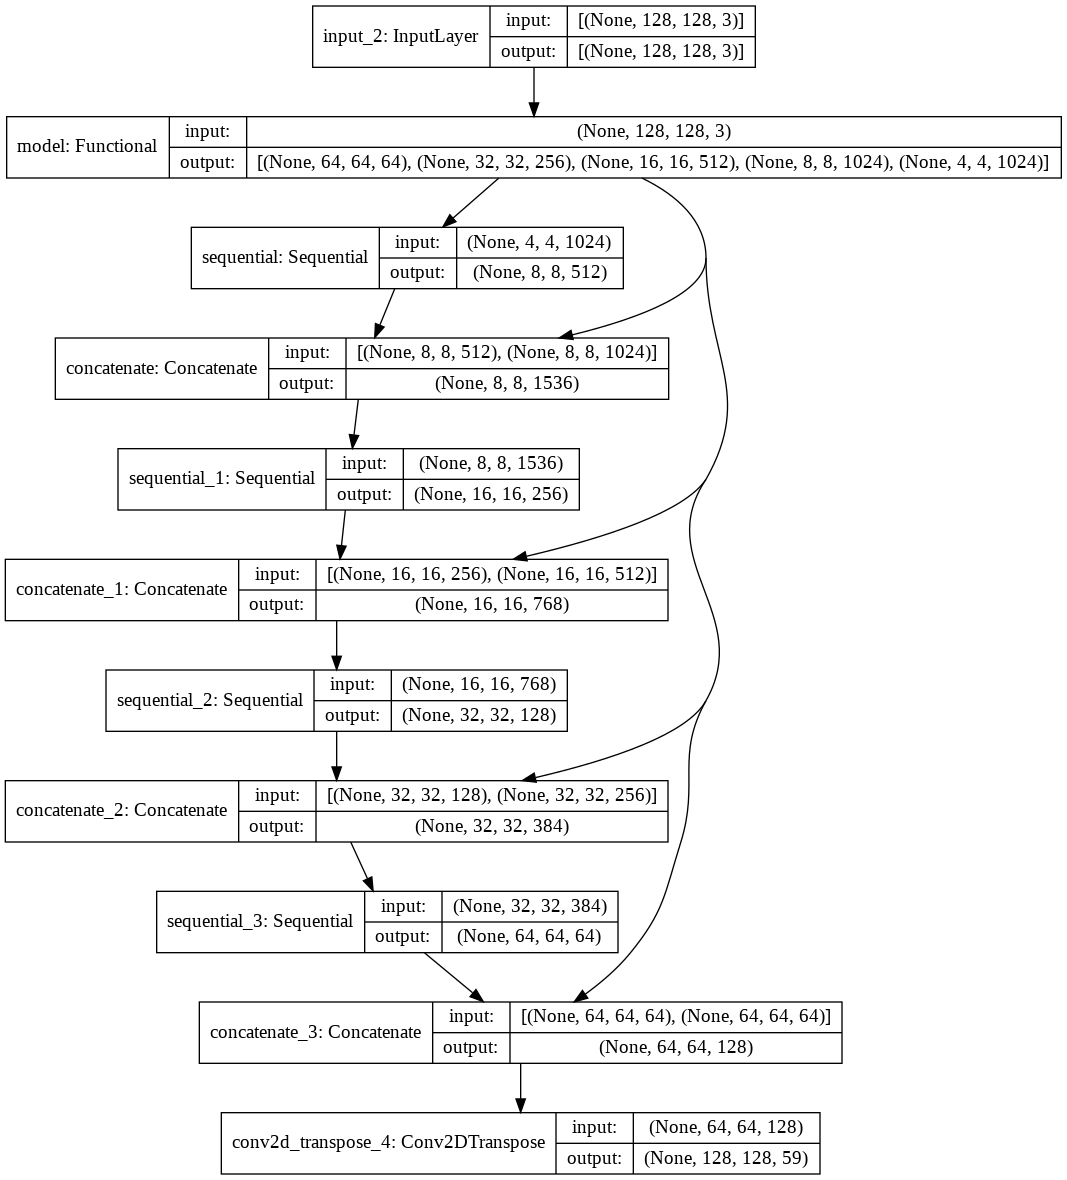

In [21]:
keras.utils.plot_model(unet, show_shapes=True)

In [22]:
def resize_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 

In [23]:
def resize_mask(mask):
     mask = tf.expand_dims(mask, axis=-1)
     mask = tf.image.resize(mask, (128,128))
     mask = tf.cast(mask, tf.uint8)
     return mask     

In [24]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks] 

In [25]:
from sklearn.model_selection import train_test_split
train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=0
                                                      )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec 

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [26]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y)) 

In [28]:
def brightness(img, mask):
     img = tf.image.adjust_brightness(img, 0.1)
     return img, mask
 
def gamma(img, mask):
     img = tf.image.adjust_gamma(img, 0.1)
     return img, mask

def hue(img, mask):
     img = tf.image.adjust_hue(img, -0.1)
     return img, mask

def crop(img, mask):
     img = tf.image.central_crop(img, 0.7)
     img = tf.image.resize(img, (128,128))
     mask = tf.image.central_crop(mask, 0.7)
     mask = tf.image.resize(mask, (128,128))
     mask = tf.cast(mask, tf.uint8)
     return img, mask

def flip_hori(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

def flip_vert(img, mask):
     img = tf.image.flip_up_down(img)
     mask = tf.image.flip_up_down(mask)
     return img, mask

def rotate(img, mask):
     img = tf.image.rot90(img)
     mask = tf.image.rot90(mask)
     return img, mask 

In [29]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

 # perform augmentation on train data only
a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g) 

In [30]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

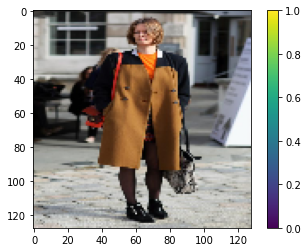

In [31]:
example = next(iter(train))
preds = unet(example[0])
plt.imshow(example[0][60])
plt.colorbar()
plt.show() 

TypeError: ignored

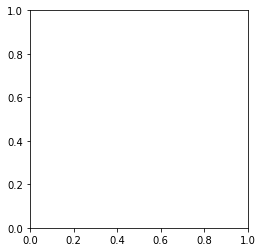

In [32]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar() 

In [33]:
unet.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.RMSprop(lr=0.001),
             metrics=['accuracy']) 

hist = unet.fit(train,
                validation_data=val,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VALIDATION_STEPS,
                epochs=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
12/12 [==============================] - 128s 10s/step - loss: 2.7629 - accuracy: 0.6227 - val_loss: 3.4548 - val_accuracy: 0.1792
Epoch 2/50
12/12 [==============================] - 122s 10s/step - loss: 1.5836 - accuracy: 0.7685 - val_loss: 2.8252 - val_accuracy: 0.6938
Epoch 3/50
12/12 [==============================] - 120s 10s/step - loss: 1.1980 - accuracy: 0.7776 - val_loss: 2.3935 - val_accuracy: 0.7130
Epoch 4/50
12/12 [==============================] - 122s 10s/step - loss: 1.2697 - accuracy: 0.7222 - val_loss: 1.7203 - val_accuracy: 0.7792
Epoch 5/50
12/12 [==============================] - 128s 11s/step - loss: 1.1652 - accuracy: 0.7305 - val_loss: 1.2585 - val_accuracy: 0.7882
Epoch 6/50
12/12 [==============================] - 121s 10s/step - loss: 0.9715 - accuracy: 0.7690 - val_loss: 1.1591 - val_accuracy: 0.7927
Epoch 7/50
12/12 [==============================] - 118s 10s/step - loss: 0.9154 - accuracy: 0.7797 - val_loss: 1.0129 - val_accuracy: 0.7843
Epoch 

KeyboardInterrupt: ignored

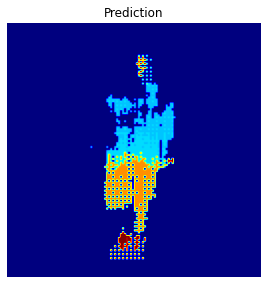

In [38]:
img, mask = next(iter(val))
pred = unet.predict(img)

plt.figure(figsize=(10,5))
for i in pred:
     plt.subplot(121)
     i = tf.argmax(i, axis=-1)
     plt.imshow(i,cmap='jet')
     plt.axis('off')
     plt.title('Prediction')
     break

#plt.subplot(122)
#plt.imshow(mask[0], cmap='jet')
#plt.axis('off')
#plt.title('Ground Truth')
#plt.show()

In [36]:
history = hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']
plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored